# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

!unzip -q data.zip

--2023-12-11 08:29:06--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-11 08:29:06--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.09s   

2023-12-11 08:29:07 (196 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        class_label = class_dict[member.find("name").text]

        res =  (xmin, ymin, xmax, ymax, class_label)

        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        image = images[i].permute(1, 2, 0).numpy() * std + mean

        ax.imshow(image)

        for bbox in bboxes[i]:
          xmin, ymin, xmax, ymax, class_id = bbox
          class_label = train_ds.class_dict_inv[class_id]

          rectangle = Rectangle(
              xy = (xmin, ymin),
              width = xmax - xmin,
              height = ymax - ymin,
              lw = 1,
              edgecolor = 'r',
              facecolor = 'none'
          )
          ax.add_patch(rectangle)
          ax.text(
              x = xmin - 5,
              y = ymin - 5,
              s = class_label,
              fontsize = 7,
              color = 'r'
          )


    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

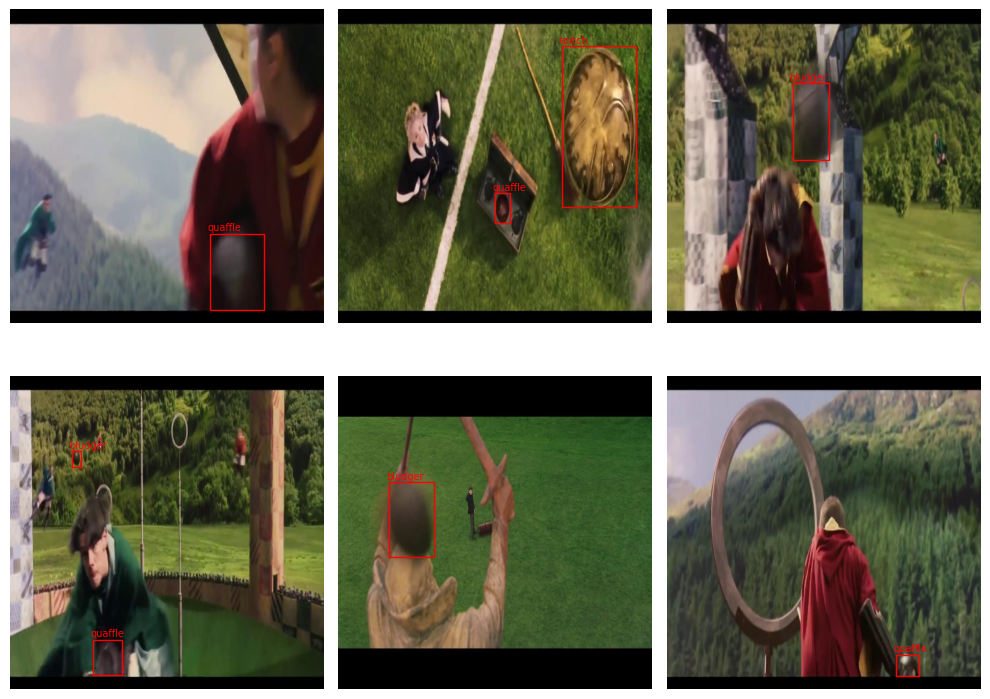

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  xmax - xmin
        y_cell =  ymax - ymin
        w_box =  x_cell / w
        h_box =  y_cell / h


        cx =  (xmax + xmin) / 2
        cy =  (ymax + ymin) / 2
        cx_idx =  (cx // downsample).long()
        cy_idx =  (cy // downsample).long()

        cx_box =  cx % downsample / downsample
        cy_box =  cy % downsample / downsample

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

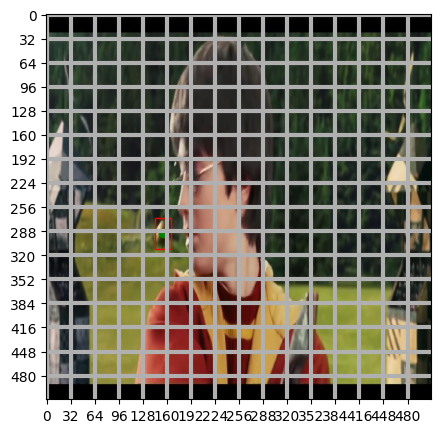

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    decoded_predictions = []

    for i in range(b):
      decoded_bboxes = []

      for y in range(h):
          for x in range(w):
              pred_yx = pred[i, :, y, x]

              if pred_yx[4] >= threshold:
                  cx_cell = pred_yx[0]
                  cy_cell = pred_yx[1]

                  cx = (cx_cell + x) * upsample
                  cy = (cy_cell + y) * upsample

                  w_box = pred_yx[3] * img_w
                  h_box = pred_yx[2] * img_h

                  xmin = cx - w_box / 2
                  xmax = cx + w_box / 2
                  ymin = cy - h_box / 2
                  ymax = cy + h_box / 2

                  class_pred = pred_yx[5:].numpy()
                  decoded_bboxes.append((xmin, ymin, xmax, ymax, np.argmax([class_pred])))

      decoded_predictions.append(decoded_bboxes)


    return decoded_predictions

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
C =  3

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet_block = nn.Sequential(*list(model.children())[:-2])

        self.my_block = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )

    def forward(self, img):
        x = self.resnet_block(img)
        x = self.my_block(x)
        x = torch.sigmoid(x)
        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
def special_loss(pred, target, check=False, C=C):
    loc_mask = target[:, :2, :, :] > 0
    masked_target_loc = target[:, :2, :, :][loc_mask]
    masked_pred_loc = pred[:, :2, :, :][loc_mask]
    loss = nn.MSELoss(reduction='sum')
    localization_loss = loss(masked_target_loc, masked_pred_loc)

    box_mask = target[:, 2:4, :, :] > 0
    masked_target_box = target[:, 2:4, :, :][box_mask]
    masked_pred_box = pred[:, 2:4, :, :][box_mask]
    box_loss = loss(torch.sqrt(masked_target_box), torch.sqrt(masked_pred_box))

    obj_mask = target[:, 4, :, :] > 0
    class_probs = torch.stack([pred[:, 5 + i, :, :][obj_mask] for i in range(C)], dim=1)
    class_labels = target[:, 5, :, :][obj_mask].to(torch.long)
    loss = nn.CrossEntropyLoss(reduction='sum')
    classification_loss = loss(class_probs, class_labels)

    confidence_losses = []
    obj_detected_mask = target[:, 4, :, :] > 0
    for i in range(pred.size(2)):
        for j in range(pred.size(3)):
            weight = torch.tensor(1.0) if obj_detected_mask[:, i, j].any() else torch.tensor(0.1)
            loss = nn.BCELoss(weight, reduction='sum')
            confidence_losses.append(loss(pred[:, 4, i, j], target[:, 4, i, j]))

    confidence_loss = torch.stack(confidence_losses).sum()

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  20
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        images, targets = batch['image'].to(device), batch['target'].to(device)
        pred = model(images)

        loss = special_loss(pred.cpu(), targets.cpu())

        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_losses.append(loss.item())

    print(f"Epoch {e + 1} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 121.269;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 37.604;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 21.809;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 19.339;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 15.193;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 13.198;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 12.504;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 11.635;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 11.019;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 10.961;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 10.873;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 10.308;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 10.473;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 8.128;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 7.222;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 6.734;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 6.532;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 6.544;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 6.649;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20 done; Train loss 6.462;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

model.eval()
images, _ = batch['image'].to(device), batch['target'].to(device)

with torch.no_grad():
    predictions = model(images)

predictions = predictions.cpu()


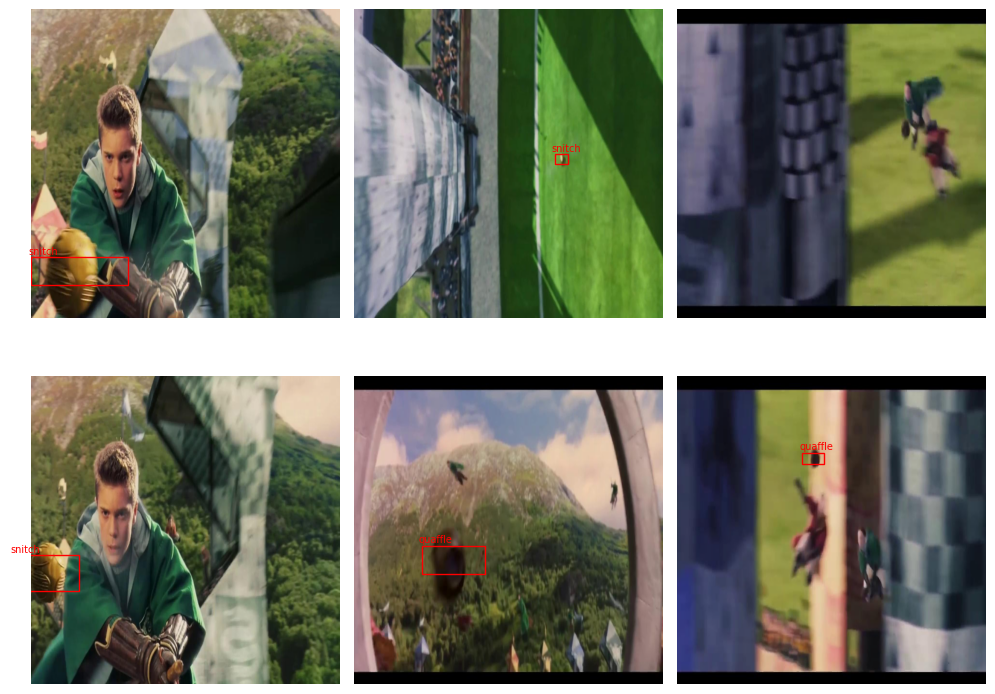

In [ ]:
visualize(batch['image'], decode_prediction(predictions, threshold=0.2))

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.4/660.4 kB 12.4 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    annotations = []
    for bbox in bboxes:
      xmin, ymin, xmax, ymax, class_id = bbox

      cx = (xmin + xmax) / 2 / w_im
      cy = (ymin + ymax) / 2 / h_im
      w = (xmax - xmin) / w_im
      h = (ymax - ymin) / h_im

      annotation = f"{class_id} {cx} {cy} {w} {h}"
      annotations.append(annotation)

    return annotations

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  len(train_ds.class_dict)
names =  list(train_ds.class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')

results = model.train(data='data.yaml', epochs=100)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 24.2MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 109MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 2250.62it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 1461.29it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.69G       4.56      9.203      4.236         30        640: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.55G      4.961      8.727      4.127         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.55G      4.132       7.88      3.931         31        640: 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.55G      3.734      6.676       3.64         38        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.55G      3.448      6.121      3.253         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.55G      3.111       5.95      2.948         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.55G      3.001      5.659      2.785         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.55G      2.847      4.891      2.575         39        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.55G      2.692      4.646      2.461         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.55G      2.765       4.34      2.346         34        640: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.55G      2.726      4.351      2.325         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.55G      2.441      3.954      2.185         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.55G      2.422      3.843      2.146         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.55G      2.444       3.54      2.196         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.55G      2.289      3.402      2.037         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.55G      2.407      3.551      1.982         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.55G      2.216        3.2      1.939         22        640: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.55G      2.229      3.307       1.96         39        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.55G      2.329      3.064      1.987         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.55G      2.175      2.935      1.898         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         35   0.000104     0.0159   6.52e-05   6.52e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.55G      2.087      2.901       1.84         30        640: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         29         35   0.000104     0.0159   6.52e-05   6.52e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.55G       2.05      2.737      1.806         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         29         35   0.000104     0.0159   6.52e-05   6.52e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.55G       2.08      2.556      1.796         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         29         35   0.000104     0.0159   6.52e-05   6.52e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.55G      2.136      2.703       1.82         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         35   0.000104     0.0159   6.52e-05   6.52e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.55G      2.001       2.41      1.731         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.55G       2.01      2.386      1.713         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.55G      1.966      2.332      1.687         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.55G      2.003      2.418      1.728         31        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.55G      1.873      2.041       1.64         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.55G       1.96      2.206      1.687         41        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.55G      1.778       2.11      1.564         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.55G      1.878      2.022      1.589         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.55G      1.792      2.054      1.538         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.55G      1.804      2.054      1.593         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.55G       1.81      2.011       1.58         36        640: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.55G      1.757      1.975       1.54         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.55G      1.786      1.915       1.51         27        640: 100%|██████████| 16/16 [00:05<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.55G      1.729      1.877      1.473         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.55G      1.784      1.862      1.516         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.55G      1.788      1.823      1.492         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.55G      1.754      1.764      1.493         34        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.55G      1.697      1.748      1.492         27        640: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.55G      1.687      1.677      1.477         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.55G      1.742      1.788      1.495         29        640: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.55G      1.597      1.615      1.391         19        640: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.55G      1.727      1.752      1.503         22        640: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.55G       1.69      1.651      1.484         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.55G      1.611       1.61      1.463         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.55G      1.558      1.477      1.383         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.55G      1.624       1.59      1.392         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.55G      1.621      1.524      1.411         33        640: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.55G      1.641       1.56      1.399         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.55G       1.62      1.494      1.408         42        640: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.55G      1.569      1.535      1.406         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.55G      1.585      1.523      1.444         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.55G      1.546      1.452      1.351         13        640: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.55G      1.566      1.451      1.367         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.55G      1.517      1.433      1.348         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.55G      1.545       1.38      1.369         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.55G      1.533      1.474       1.31         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.55G      1.474      1.349      1.288         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.55G      1.502      1.405      1.364         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.55G      1.486      1.309      1.347         33        640: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.55G      1.523      1.354       1.35         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.55G       1.49       1.32       1.34         22        640: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.55G      1.502      1.311       1.35         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.55G      1.499      1.298      1.346         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.55G      1.506       1.33      1.301         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.55G      1.452      1.284      1.309         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.55G      1.411      1.319      1.361         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.55G      1.434      1.281      1.313         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.55G      1.408       1.23      1.263         34        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.55G      1.404      1.166      1.244         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.55G      1.448      1.274      1.268         29        640: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.55G      1.386      1.183      1.252         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.55G      1.402      1.191      1.244         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.55G      1.346      1.133      1.252         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.55G      1.393      1.143      1.267         36        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.55G      1.349      1.182      1.283         21        640: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.55G      1.402      1.139      1.283         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.55G      1.321      1.119       1.27         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.55G      1.326      1.126       1.22         39        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.55G      1.374       1.16      1.243         28        640: 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.55G      1.332       1.09       1.25         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.55G      1.332       1.07      1.228         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.55G        1.3      1.061      1.264         24        640: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.55G      1.324      1.145      1.276         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.55G      1.346      1.141      1.287         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.55G      1.351      1.154      1.245         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.55G      1.306      1.044      1.218         32        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.55G      1.361      1.241        1.3         18        640: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.55G      1.257      1.167      1.228         14        640: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.55G      1.322      1.198       1.26         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.55G      1.259      1.109      1.243         17        640: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.55G      1.274      1.097      1.254         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.55G      1.258      1.095      1.214         17        640: 100%|██████████| 16/16 [00:04<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.55G      1.242      1.074      1.217         15        640: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.55G      1.245      1.035       1.23         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.55G      1.237      1.021      1.219         18        640: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.55G      1.217      1.021      1.188         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06



100 epochs completed in 0.186 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         29         35   0.000145     0.0159   8.22e-05   8.22e-06
                snitch         29          6          0          0          0          0
               quaffle         29         21   0.000436     0.0476   0.000247   2.47e-05
               bludger         29          8          0          0          0          0


Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

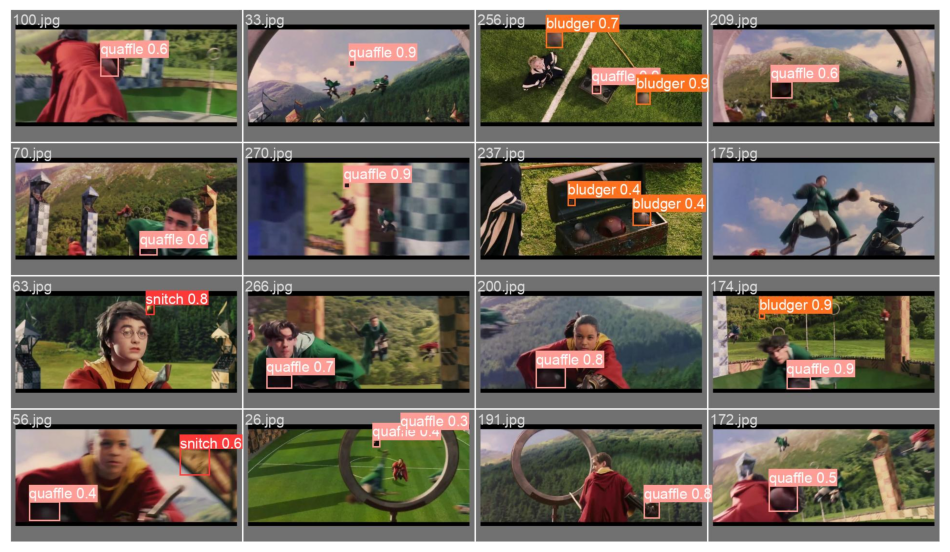

In [ ]:
import matplotlib.image as mpimg

img = mpimg.imread('./runs/detect/train/val_batch0_pred.jpg') # оказывается YOLO сам за меня все отрисовал

fig, ax = plt.subplots(figsize=(12,8))

plt.imshow(img)
plt.axis('off')
plt.show()

# Отсюда черпалось вдохновение:

* https://www.kaggle.com/code/gokifujiya/face-mask-object-detection-with-xml-file
* https://dev.to/andreygermanov/a-practical-introduction-to-object-detection-with-yolov8-neural-network-3n8c#prepare_data
*   https://inside-machinelearning.com/en/yolov8-how-to-use/
*   https://inside-machinelearning.com/en/bounding-boxes-python-function/
* https://giters.com/apple/coremltools/issues/1339?ysclid=lpmkjfduhg682978453
